In [ ]:
!pip install crcmod
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

!gsutil -m -o 'GSUtil:parallel_composite_upload_threshold_1M''GSUtil:sliced_object_download_max_components=8' cp -r gs://evenergy163.appspot.com/data/** .

Copying gs://evenergy163.appspot.com/data/evwatts.public.connector.csv...
Copying gs://evenergy163.appspot.com/data/annual_generation_state.xlsx...
Copying gs://evenergy163.appspot.com/data/Monthly Gas Prices.csv...
Copying gs://evenergy163.appspot.com/data/California Electric Rates.csv...
Copying gs://evenergy163.appspot.com/data/HS861 2010-.xlsx...
Copying gs://evenergy163.appspot.com/data/evwatts.public.dictionary.txt...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehicles.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.evse.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.session.csv...
Copying gs://evenergy163.appspot.com/data/HS861M 2010-.xlsx...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehiclesessions.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehicletrips.csv...
Copying gs://evenergy163.appspot.com/data/generation_monthly.xlsx...
Copying gs://evenergy163.appspot.com/data/iea.png...


In [ ]:
session_data = pd.read_csv('evwatts.public.session.csv')
evse_data = pd.read_csv('evwatts.public.evse.csv')
merged_data = pd.merge(session_data, evse_data[['evse_id', 'charge_level', 'region', 'metro_area']], on='evse_id', how='left')
session_data = merged_data

session_data['start_datetime'] = pd.to_datetime(session_data['start_datetime'])
session_data['year_month'] = session_data['start_datetime'].dt.to_period('M')
session_data.head(5)

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,charge_level,region,metro_area,year_month
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,L2,Middle Atlantic,Undesignated,2020-03
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212,NaN,NaN,0,L2,Middle Atlantic,Undesignated,2020-03
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,L2,Middle Atlantic,"Rochester, NY Metro Area",2020-03
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",2020-03
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527,NaN,NaN,0,L2,Middle Atlantic,"Albany-Schenectady-Troy, NY Metro Area",2020-02


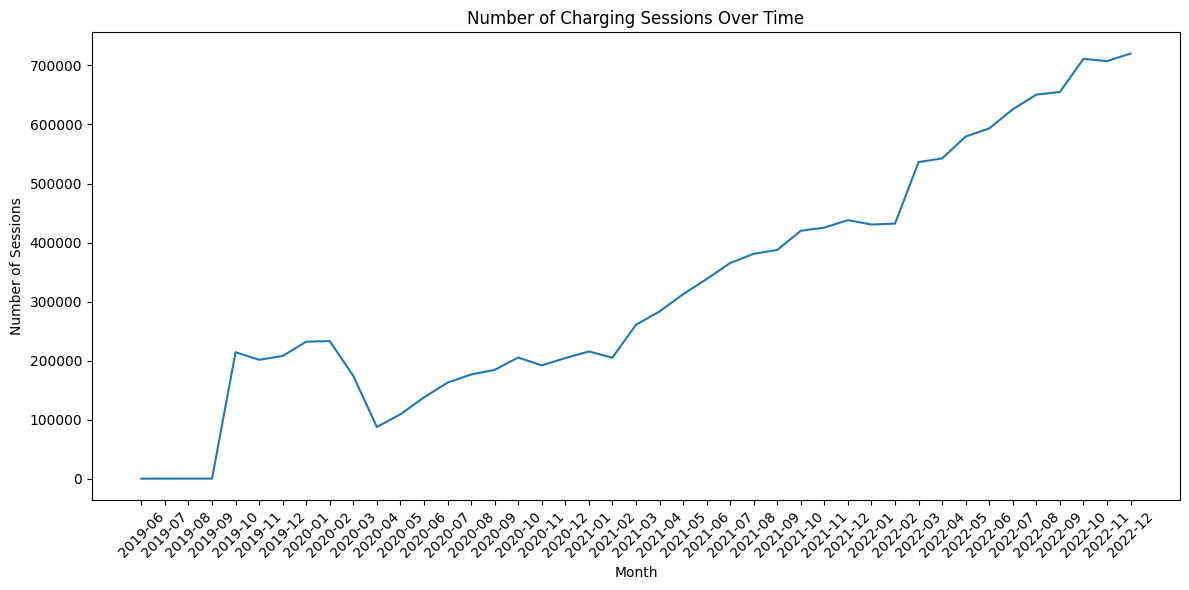

In [ ]:
session_data['year_month'] = session_data['start_datetime'].dt.to_period('M')

monthly_sessions = session_data.groupby('year_month')['session_id'].count().reset_index()
monthly_sessions['year_month'] = monthly_sessions['year_month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sessions, x='year_month', y='session_id')
plt.title('Number of Charging Sessions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Sharp rise in late 2019, likely when data collection or adoption began.

COVID dip in early 2020.

Strong linear growth from mid-2020 to end of 2022.

Shows how often EVs are being plugged in to charge.

Clear growth trend after early adoption, especially strong post-2020.

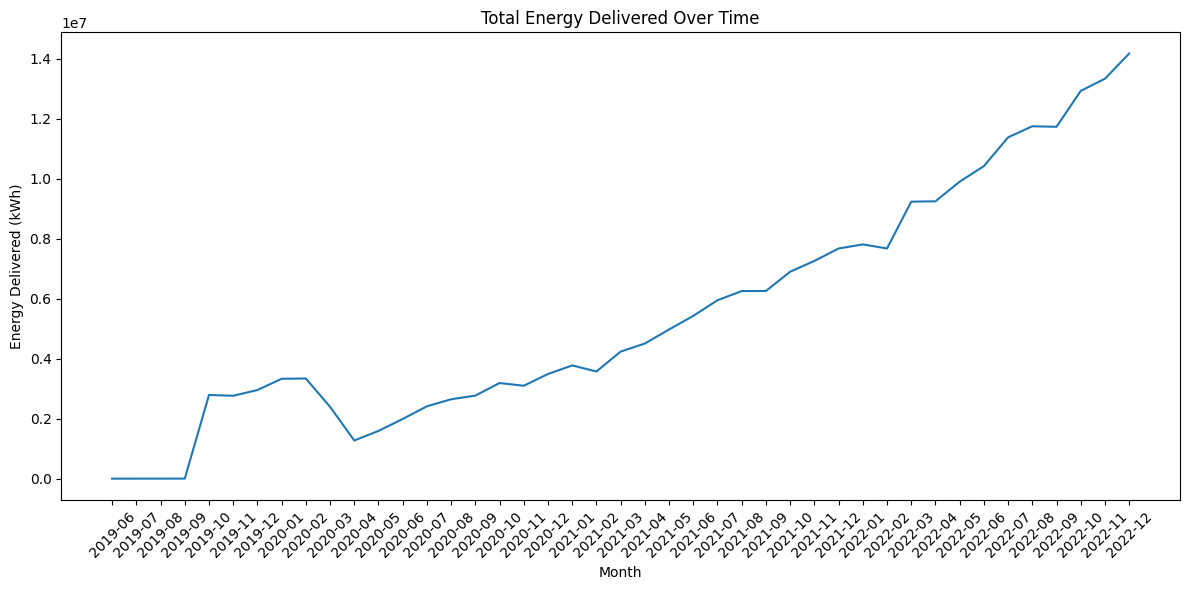

In [ ]:
monthly_energy = session_data.groupby('year_month')['energy_kwh'].sum().reset_index()
monthly_energy['year_month'] = monthly_energy['year_month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_energy, x='year_month', y='energy_kwh')
plt.title('Total Energy Delivered Over Time')
plt.xlabel('Month')
plt.ylabel('Energy Delivered (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Shape is almost identical to Plot 1.

Also shows a big jump, dip, then steady linear rise.

Indicates total energy demand from EV charging.

Nearly mirrors the session growth trend, but the slope is slightly steeper over time.

Similarity between plots confirms that total energy use is largely driven by the growing number of sessions.

Slight divergence over time (energy growing a bit faster) is due to increasing average energy per session — reflecting:

Larger EV battery sizes,

Longer trips,

Or lower starting SOCs (users waiting longer to charge).

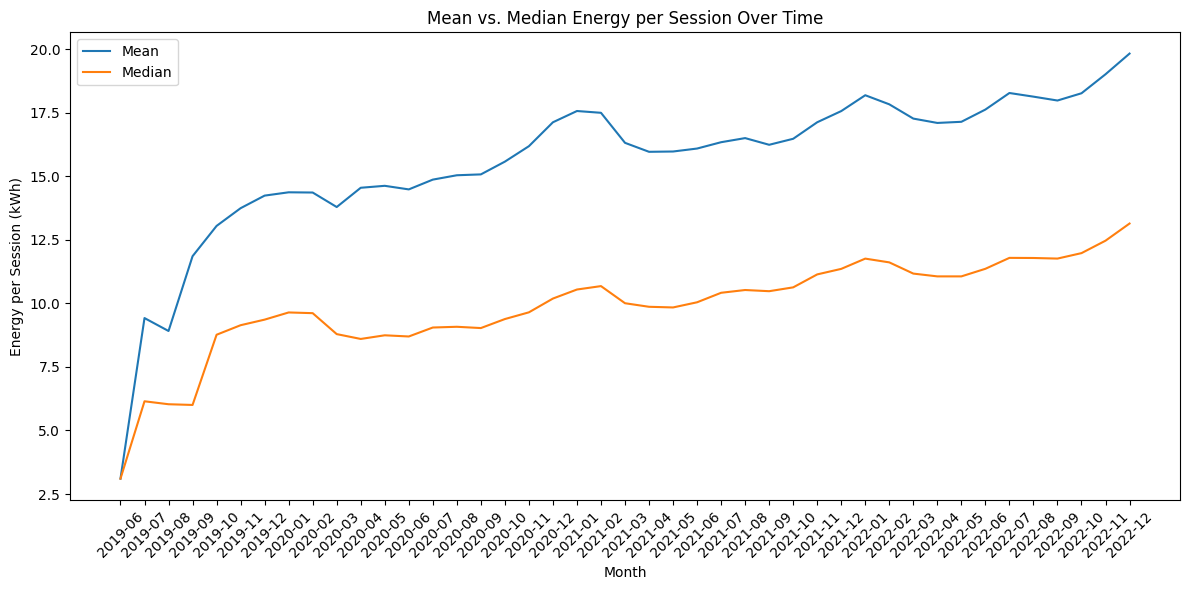

In [ ]:
median_energy_per_session = session_data.groupby('year_month')['energy_kwh'].median().reset_index(name='median_energy_per_session')
mean_df = session_data.groupby('year_month')['energy_kwh'].mean().reset_index(name='mean_energy')
median_df = session_data.groupby('year_month')['energy_kwh'].median().reset_index(name='median_energy')

# Merge
combined = pd.merge(mean_df, median_df, on='year_month')
combined['year_month'] = combined['year_month'].astype(str)

# Plot both
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined, x='year_month', y='mean_energy', label='Mean')
sns.lineplot(data=combined, x='year_month', y='median_energy', label='Median')
plt.title('Mean vs. Median Energy per Session Over Time')
plt.xlabel('Month')
plt.ylabel('Energy per Session (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Starts low (~3 kWh), then ramps up and stabilizes between 14–20 kWh.

Indicates that people are using more energy per session over time.


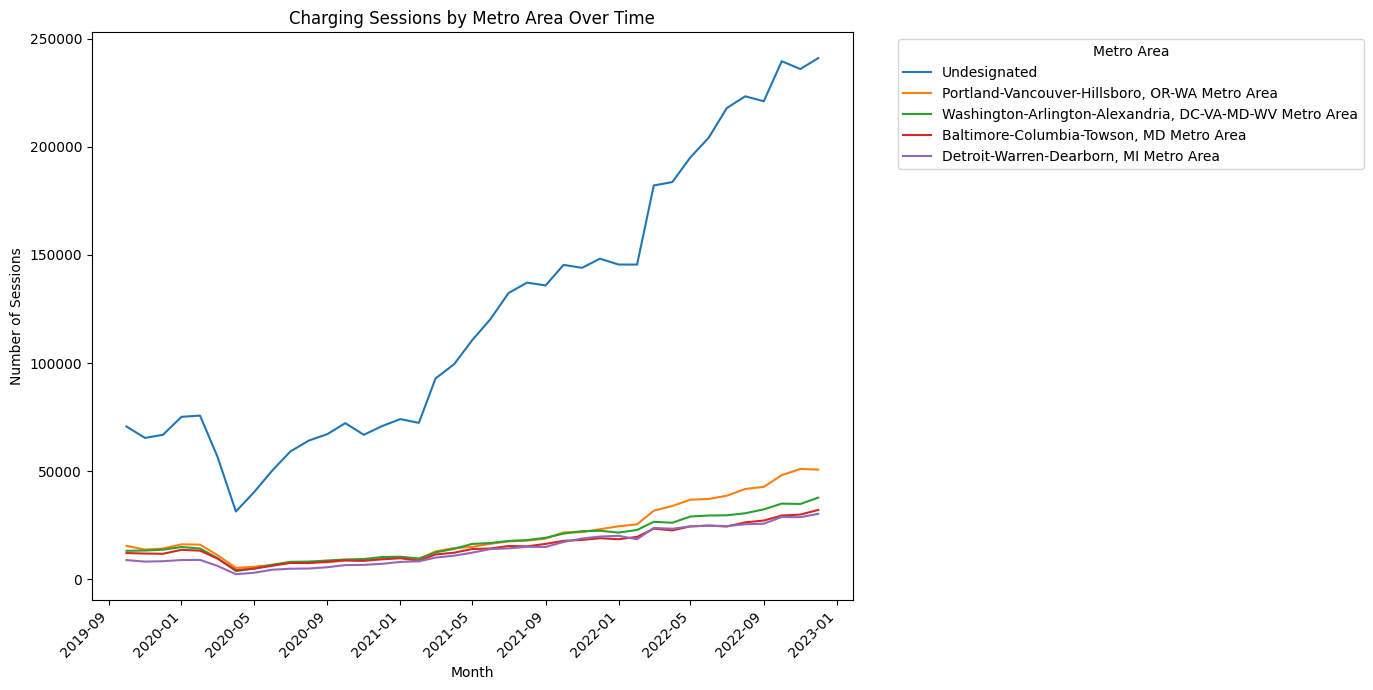

In [ ]:
session_data['year_month'] = session_data['start_datetime'].dt.strftime('%Y-%m')
session_data['year_month'] = pd.to_datetime(session_data['year_month'])

# Step 1: Get total sessions per metro
metro_totals = session_data.groupby('metro_area')['session_id'].count().sort_values(ascending=False)
top_metros = metro_totals.head(5).index.tolist()  # top 5 metros

# Step 2: Filter and aggregate
region_monthly = session_data[session_data['metro_area'].isin(top_metros)].groupby(
    ['year_month', 'metro_area']
)['session_id'].count().reset_index()

# Step 3: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=region_monthly,
    x='year_month',
    y='session_id',
    hue='metro_area',
    hue_order=top_metros
)
plt.title('Charging Sessions by Metro Area Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metro Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Undesignated" sessions dominate, growing from ~70K/month in 2019 to over 240K/month by early 2023.

Portland-Vancouver-Hillsboro, OR-WA is the top designated metro area, rising from ~15K to 50K sessions/month.

Washington DC, Baltimore, and Detroit show steady growth, each reaching 30K–35K sessions/month by 2023.

All areas saw a sharp dip around early 2020, likely due to COVID-19.

Growth accelerated significantly from 2021 onward, with the most rapid increases in "Undesignated" and Portland areas.

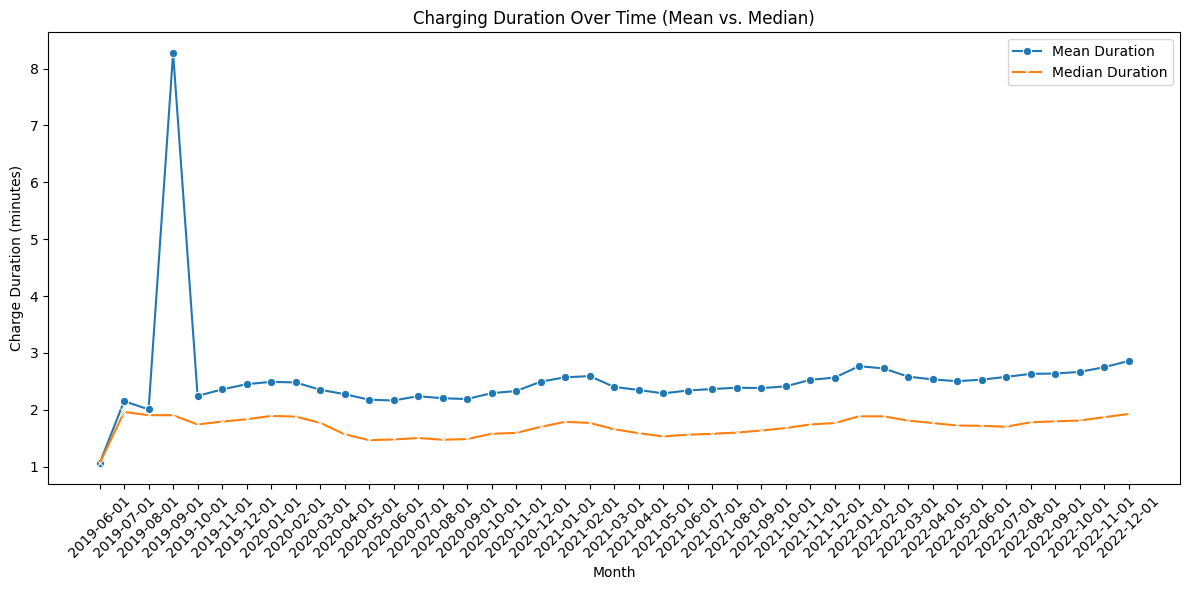

In [ ]:
# Filter out negative or zero charge durations
valid_durations = session_data[session_data['charge_duration'] > 0]
median_duration_trend = valid_durations.groupby('year_month')['charge_duration'].median().reset_index(name='median_duration')

# Mean
mean_duration = valid_durations.groupby('year_month')['charge_duration'].mean().reset_index(name='mean_duration')

# Median
median_duration = valid_durations.groupby('year_month')['charge_duration'].median().reset_index(name='median_duration')

# Merge for plotting
combined = pd.merge(mean_duration, median_duration, on='year_month')
combined['year_month'] = combined['year_month'].astype(str)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined, x='year_month', y='mean_duration', label='Mean Duration', marker='o')
sns.lineplot(data=combined, x='year_month', y='median_duration', label='Median Duration', marker='x')
plt.title('Charging Duration Over Time (Mean vs. Median)')
plt.xlabel('Month')
plt.ylabel('Charge Duration (minutes)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Initial spike: There’s a sharp peak around September 2019, where the average charging duration jumps above 8 hours — likely due to data anomaly or very low session counts skewing the average.

Stabilization: After that spike, the duration stabilizes between 2–2.6 hours for most of the period.

Slight upward trend: From late 2021 into 2022, there’s a gradual increase, with the average duration rising to nearly 3 hours by the end of 2022.



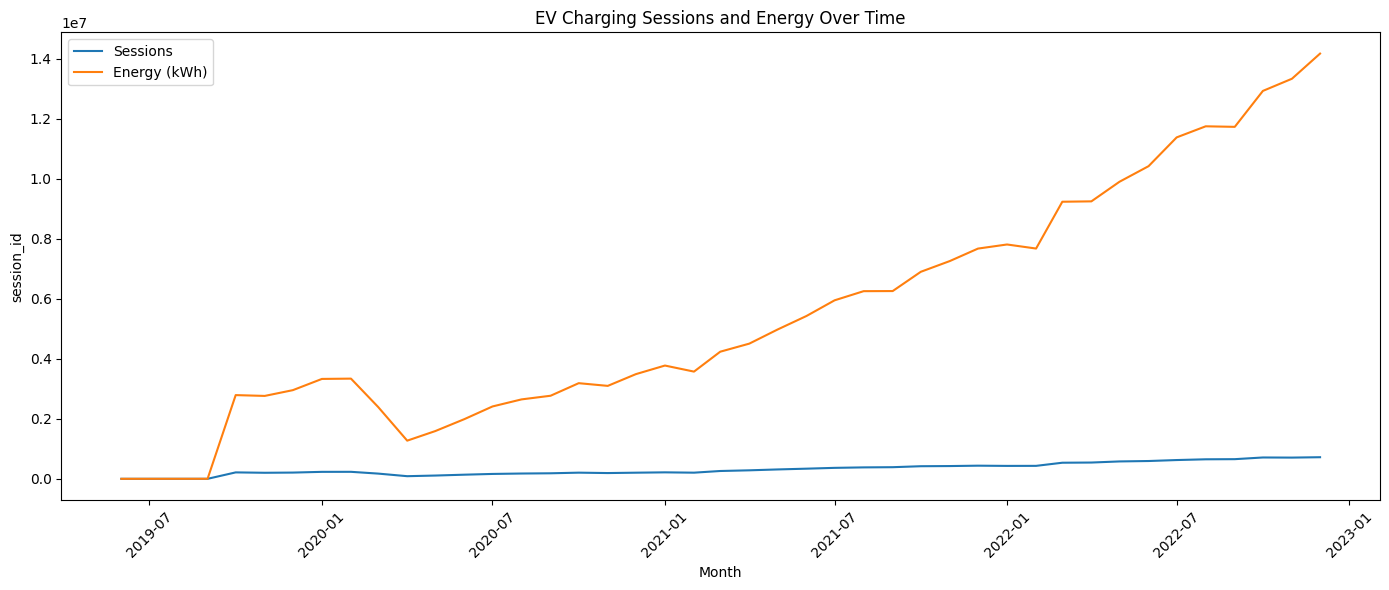

In [ ]:
# Aggregate
monthly = session_data.groupby('year_month').agg({
    'session_id': 'count',
    'energy_kwh': 'sum'
}).reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly, x='year_month', y='session_id', label='Sessions')
sns.lineplot(data=monthly, x='year_month', y='energy_kwh', label='Energy (kWh)')
plt.title('EV Charging Sessions and Energy Over Time')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Energy (kWh) (orange line) and Charging Sessions (blue line) both show strong upward trends, with energy growing more steeply.

Energy consumption rises from nearly 0 in early 2019 to over 14 million kWh/month by end of 2022.

Sessions increase gradually from under 1 million to about 8 million over the same period.

The gap between energy and sessions widens, suggesting:

Longer charging durations or

Higher energy per session, possibly due to larger EV batteries or more extensive use of Level 2/3 chargers.

 Notable Points:
Early data (2019) shows inconsistent or low values, likely due to partial data.

Energy growth is exponential, especially post-2021—outpacing the linear growth in session counts.